# Classification using pytorch

In this exercise, PyTorch is used to perform a binary classification task. First, logistic regression is implemented, and it is observed that it performs rather poorly. Then, a simple neural network is implemented, showing that the classification performance can be greatly improved.

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

print('Run on cpu')
dtype = torch.FloatTensor
device = torch.device("cpu")

# fix random generators seed for reproducibility
torch.manual_seed(42)
np.random.seed(seed=42)


Run on cpu


# Generation of the samples

Cells below to generate the two classes: a 'background' sample and a 'signal' sample.

In [2]:
Nsample = 10000 # Number of events in each sample
features=["x0","x1","x2","x3","x4","x5"] # feature names

In [3]:
# Generation of background sample
# The first 5 features are samples from a multi-dimensional gaussian function. 
# The 6-th feature is constructed from the 5 others.

covMatrix = np.array([[ 0.81652219,  0.12798401,  0.25894314, -0.65065863,  1.24887103],
       [ 0.12798401,  0.90369306, -0.0297507 , -0.27944877,  2.31268408],
       [ 0.25894314, -0.0297507 ,  1.27407394,  0.5200441 , -0.0738098 ],
       [-0.65065863, -0.27944877,  0.5200441 , 19.43674212, -5.04547895],
       [ 1.24887103,  2.31268408, -0.0738098 , -5.04547895, 23.93837133]])

Nvar = 5
mean = np.random.randn(Nvar)
cov = covMatrix
x = np.random.multivariate_normal(mean, cov, Nsample)
print(f"dim(x) = {x.shape}")


# 6-th feature

m = np.sqrt(np.sum(x**2,axis=1))
m = m.reshape(Nsample,1)


# Put sample in a panda dataframe

data = np.concatenate((x,m),axis=1)
background = pd.DataFrame(data,columns=features)

dim(x) = (10000, 5)


In [4]:
# Now we generate the signal sample
# We use a custom function from scikit-learn that generates 'blobs' of data

from sklearn.datasets import make_blobs
centers = [[0,2,-2,0,0,6]] # center of the blobs
X, y = make_blobs(n_samples=Nsample, cluster_std=2.5, centers=centers, n_features=6, random_state=40)

signal = pd.DataFrame(X,columns=features)

In [5]:
# Here we add a column of label to each sample: 0=background, 1=signal

z=pd.DataFrame(np.zeros(len(background)))
background["label"]=pd.DataFrame(z)

o=pd.DataFrame(np.ones(len(signal)))
signal["label"]=pd.DataFrame(o)

## Data exploration

         x0        x1        x2        x3        x4        x5  label
0  2.434971 -1.352403 -4.495287  2.768055  1.367316  4.905633    1.0
1 -0.280529  2.643130 -2.902931  0.293859  2.357080  4.807696    1.0
2  1.928340  0.480649 -4.690930  2.167780 -0.696424  8.728022    1.0
3 -2.067082  1.146034 -1.377847 -1.109117  4.641384  5.737541    1.0
4  0.071473  3.419988 -6.380707 -0.048132 -4.448059  6.318550    1.0
signal dim = (10000, 7)
bkgnd dim = (10000, 7)


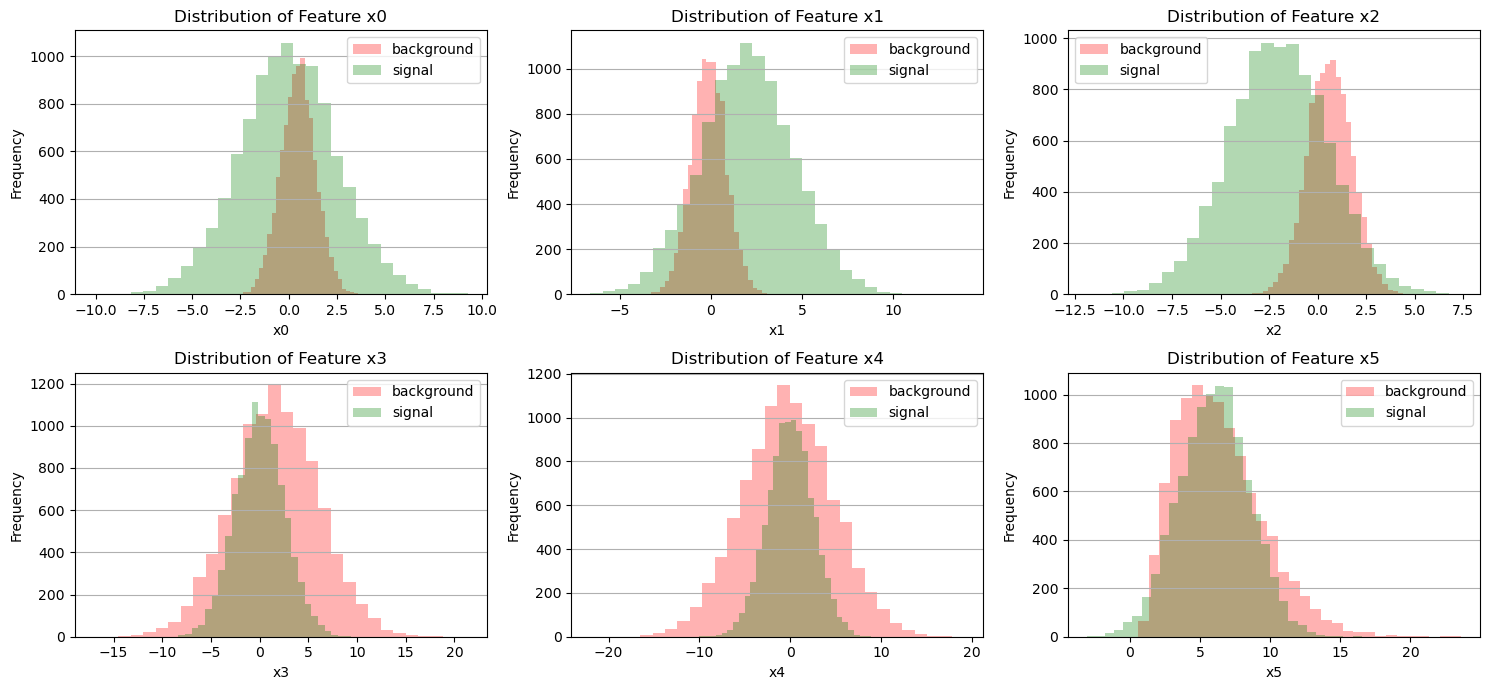

In [6]:
# Quick scan of dimension of data:

print(signal.head())
print(f"signal dim = {signal.values.shape}")
print(f"bkgnd dim = {background.values.shape}")


# Make histograms of each features for both classes

plt.figure(figsize = (15,7))
for i,name in enumerate(features):
    plt.subplot(2,3,i+1)
    plt.title(f"Distribution of Feature x{i}")
    plt.hist(background[name], bins = 30, color = "red", label = "background", alpha = 0.3)
    plt.hist(signal[name], bins = 30, color = "green", label = "signal", alpha = 0.3)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, axis = "y")
plt.tight_layout()
plt.savefig("distribution_feature_class.png", dpi = 300)


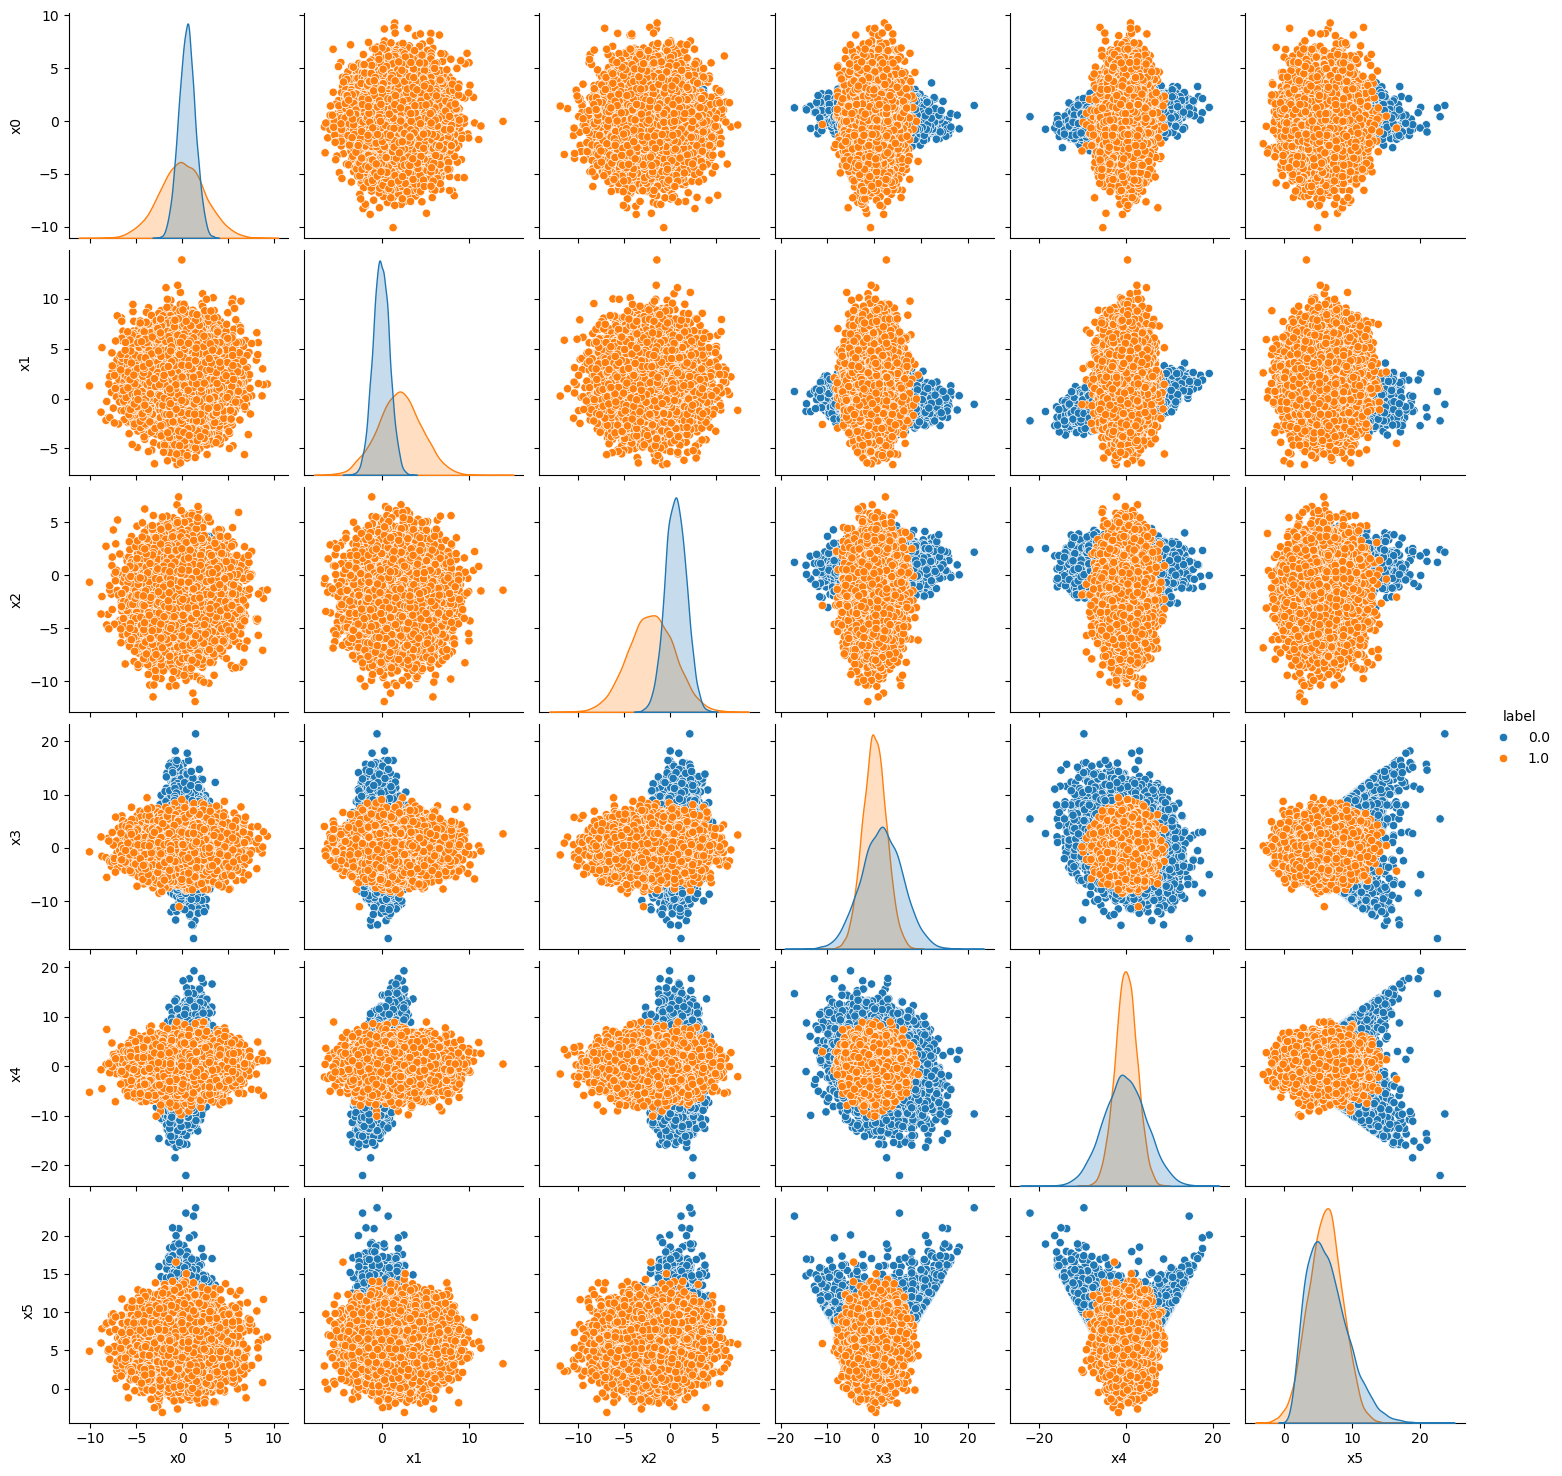

In [7]:
# Look at how the features are correlated, for both classes

g = sns.pairplot(pd.concat([background,signal]),hue = 'label')
g.savefig("correlation_feature_class.png", dpi=300, bbox_inches="tight")

# Prepare the data for pytorch

First, each sample is split into three datasets: training, validation, and test, with fractions of 40%, 20%, and 40%, respectively.

These datasets are then passed to the DataLoader utility, which facilitates batching the data for training.


In [27]:
# Separate train, validation and test data (40,20,40)

x_background_train,x_background_test = train_test_split(background.values,test_size=0.4) 
x_background_train_train,x_background_train_valid = train_test_split(x_background_train,test_size=0.33) 

x_signal_train,x_signal_test = train_test_split(signal.values,test_size=0.4) 
x_signal_train_train,x_signal_train_valid = train_test_split(x_signal_train,test_size=0.33) 

In [28]:
# Feed data into data loader

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_train,x_signal_train_train)),
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_valid,x_signal_train_valid)),
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_test,x_signal_test)),
                                          batch_size=batch_size,
                                          shuffle=False)

# Build models

1) First model class that implements the logistic regression method.
- input layer (6 nodes)
- output layer (1 node)
- Sigmoid activation function

2) Second model class that implements a simple MLP with the following structure:
- input layer (6 nodes)
- hidden layer with 200 nodes
- ReLU activation function
- output layer (1 node)
- Sigmoid activation function

Examples in: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [29]:
# set dimension of models

input_dim, hidden_dim, output_dim = 6, 200, 1

In [30]:
# Set Logistic regression

class LogRegression(nn.Module):
    
    def __init__(self, D_in, D_out):
        """
        In the constructor we instantiate one nn.Linear module and assign it as
        member variables.
        """
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, D_out)
        self.activation = torch.nn.Sigmoid()  # Sigmoid as activation function
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.activation(self.linear1(x))
        return x

LogReg = LogRegression(input_dim,output_dim)    

In [31]:
# Set MLP with one hidden layer

class MLP(nn.Module):
    
    def __init__(self, D_in, D_hidden, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super().__init__()
        self.linear1 = torch.nn.Linear(D_in, D_hidden)
        self.activation1 = torch.nn.ReLU()  # ReLU as activation function for last layer
        self.linear2 = torch.nn.Linear(D_hidden, D_out)
        self.activation2 = torch.nn.Sigmoid()
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = self.activation1(self.linear1(x))
        x = self.activation2(self.linear2(x))
        return x

MultiLayerP = MLP(input_dim, hidden_dim, output_dim)

# Train model

In [13]:
# Choose and initialise your model

model = LogReg


# Choose number of epochs

num_epochs = 50


# Setup the Binary Cross Entropy loss function

criterion = nn.BCELoss() 


# Optimisation model, here we choose Adam which is stochastic gradient descent with improvements

optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5) 

In [14]:
# Track the training and validation loss as the model trains

train_loss = []
valid_loss = []


# Track the average training and validation loss per epoch as the model trains

avg_train_loss = []
avg_valid_loss = [] 


# Train and validate

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        # ===================forward=====================
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record validation loss
        train_loss.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # record validation loss
        valid_loss.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_losses = np.average(train_loss)
    valid_losses = np.average(valid_loss)
    avg_train_loss.append(train_losses)
    avg_valid_loss.append(valid_losses)
    epoch_len = len(str(num_epochs))

    print_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_losses:.5f} ' +
                 f'valid_loss: {valid_losses:.5f}')

    if (epoch==0 or (epoch+1)%10==0):
        #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        print(print_msg)

    # clear lists to track next epoch
    train_loss = []
    valid_loss = []

#print('Final loss value: %.4f' % train_loss[-1])


[ 1/50] train_loss: 0.92439 valid_loss: 0.80242
[10/50] train_loss: 0.41409 valid_loss: 0.40705
[20/50] train_loss: 0.39036 valid_loss: 0.39157
[30/50] train_loss: 0.38903 valid_loss: 0.39073
[40/50] train_loss: 0.38873 valid_loss: 0.39072
[50/50] train_loss: 0.38894 valid_loss: 0.39079


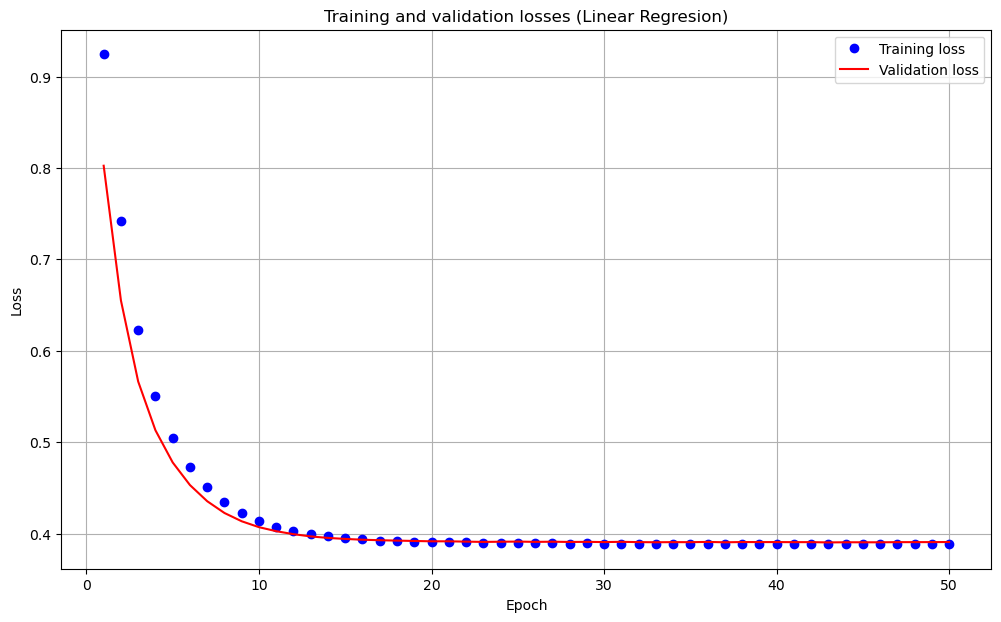

In [15]:
# Plot performance

epochs = range(1,num_epochs+1)
plt.figure(figsize= (12,7))
plt.plot(epochs, avg_train_loss, 'bo', label='Training loss')
plt.plot(epochs, avg_valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses (Linear Regresion)')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("loss_train_val_linear_regresion.png", dpi = 300)
plt.show()

# Test phase and results

For both models (logistic regression then MLP)the following steps are done:

- Apply the trained model to test samples

- Show the histograms of the model output for both background and signal samples. 

- Display the confusion matrix (threshold = 0.5)

- Show the ROC curve


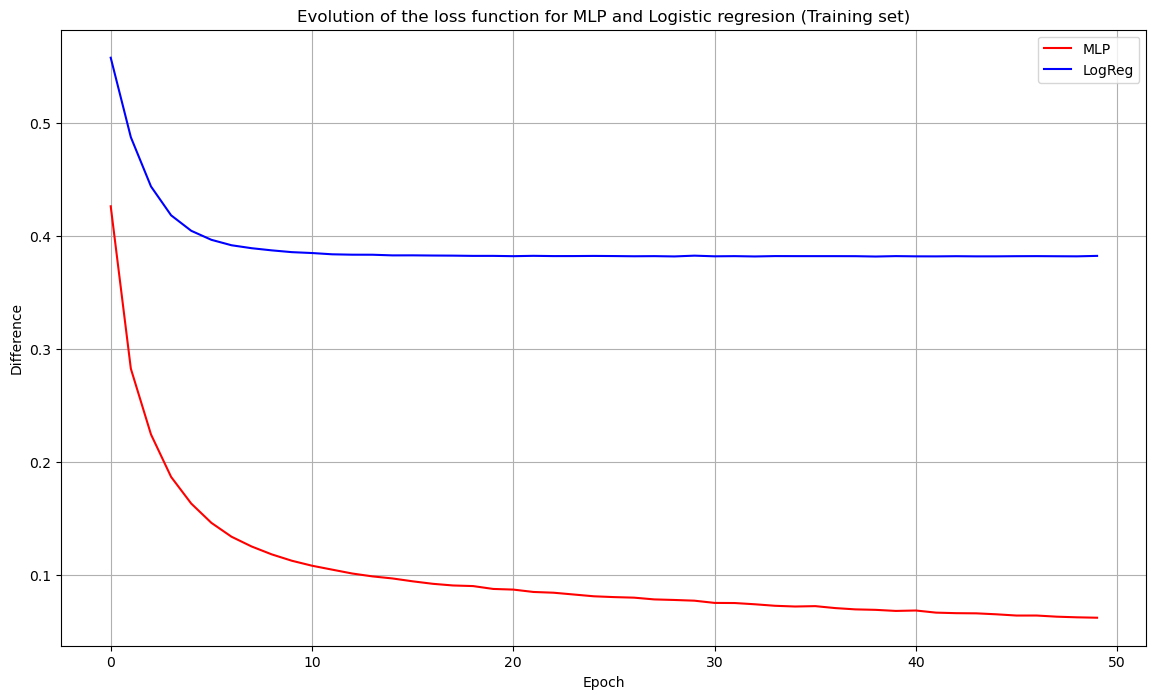

In [32]:
# train two models and compare

# Models

model_mlp = MultiLayerP   # MLP
model_reg = LogReg        # Logistic Regresion


# Parameters

learning_rate = 0.001
penalization = 1e-5            # penalization term in loss function
num_epochs = 50                # number of epochs
loss_function = nn.BCELoss()   # Binary Cross Entropy loss function
#we choose Adam which is stochastic gradient descent with improvements 
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate, weight_decay=penalization)
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=learning_rate, weight_decay=penalization)


# Track the loss as the model trains

loss_train_mlp = []
loss_train_reg = []


# Training

for epoch in range(num_epochs):

    # Prepare models for training
    
    model_mlp.train()
    model_reg.train()

    # track the loss at each epoch to get mean
    
    loss_avg_mlp = []
    loss_avg_reg = []
    
    for data in train_loader:
        data = data.type(dtype)
        # Fordward ======================================
        output_mlp = model_mlp(data[:,:input_dim])[:,0]  # Multi-Layer Perceptron
        output_reg = model_reg(data[:,:input_dim])[:,0]  # Logistic Regresion
        target = data[:,input_dim]  # target is the same for both
        # Backward ======================================
        loss_mlp = loss_function(output_mlp, target)  # Multi-Layer Perceptron
        loss_reg = loss_function(output_reg, target)  # Logistic Regresion
        optimizer_mlp.zero_grad()
        optimizer_reg.zero_grad()
        loss_mlp.backward()
        loss_reg.backward()
        # Gradient step ================================
        optimizer_mlp.step()
        optimizer_reg.step()
        loss_avg_mlp.append(loss_mlp.item())
        loss_avg_reg.append(loss_reg.item())
        
    # save Loss
    
    loss_train_mlp.append(np.mean(loss_avg_mlp))
    loss_train_reg.append(np.mean(loss_avg_reg))


# Plotting the loss evolution

plt.figure(figsize=(14,8))
plt.title("Evolution of the loss function for MLP and Logistic regresion (Training set)")
plt.plot(range(len(loss_train_mlp)), loss_train_mlp, color = "red", label = "MLP")
plt.plot(range(len(loss_train_reg)), loss_train_reg, color = "blue", label = "LogReg")
plt.xlabel("Epoch")
plt.ylabel("Difference")
plt.grid()
plt.legend()
plt.savefig("loss_comparison_MLP_LogReg_train.png", dpi = 300)

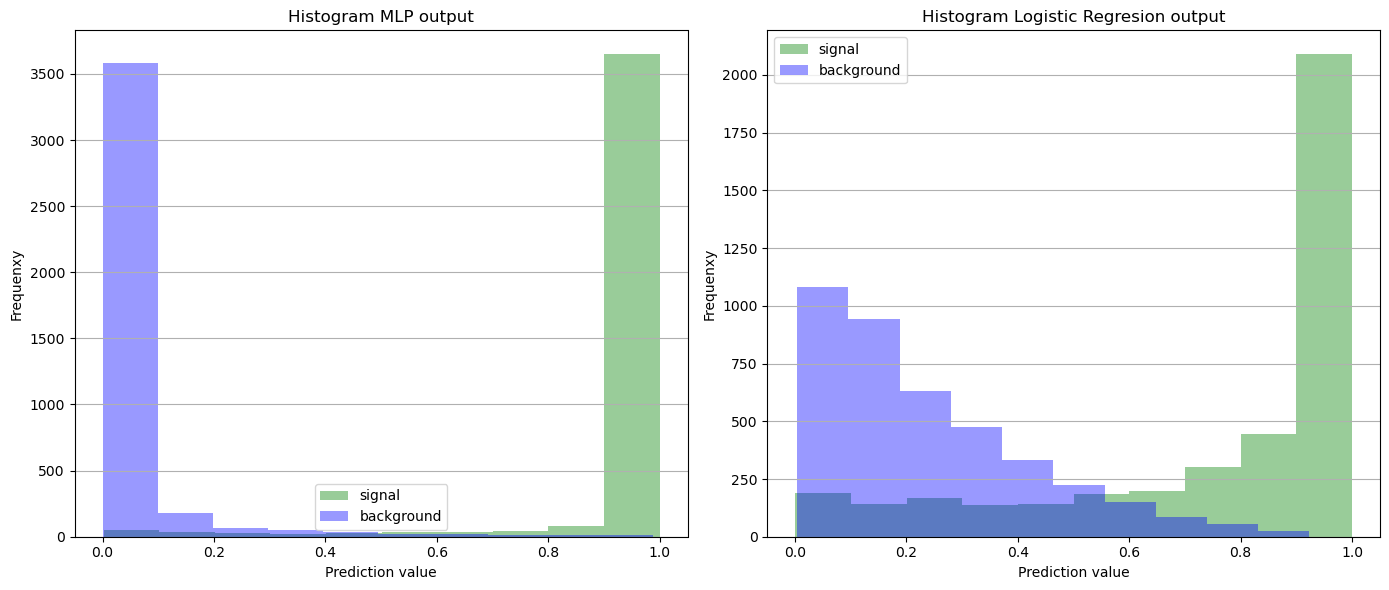

In [33]:
# Apply trained model to the test samples

# To save the target and prediction for future metrics

prediction_mlp = []
prediction_reg = []
target = [] # same fot both


# preparing models for test

model_mlp.eval()
model_reg.eval()
with torch.no_grad():    
    
    # test 
    for data in test_loader:
        data = data.type(dtype)
    
        # Predict values on the test sample
        
        output_mlp = model_mlp(data[:,:input_dim])[:,0]
        output_reg = model_reg(data[:,:input_dim])[:,0]
        target_val = data[:,input_dim]
    
        # Save predictions and target
        
        prediction_mlp.append(output_mlp)
        prediction_reg.append(output_reg)
        target.append(target_val)


# converting to a numpy array of dim(0)

prediction_mlp = torch.cat(prediction_mlp).cpu().numpy()
prediction_reg = torch.cat(prediction_reg).cpu().numpy()
target = torch.cat(target).cpu().numpy()

# Plot distribution of signal and background

#MLP
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title("Histogram MLP output")
plt.hist(prediction_mlp[target == 1], color = "green",  label = "signal", alpha = 0.4) 
plt.hist(prediction_mlp[target == 0], color = "blue",  label = "background", alpha = 0.4)
plt.xlabel("Prediction value")
plt.ylabel("Frequenxy")
plt.legend()
plt.grid(True, axis = "y")

# LogReg
plt.subplot(1,2,2)
plt.title("Histogram Logistic Regresion output")
plt.hist(prediction_reg[target == 1], color = "green", label = "signal", alpha = 0.4)
plt.hist(prediction_reg[target == 0], color = "blue", label = "background", alpha = 0.4)
plt.xlabel("Prediction value")
plt.ylabel("Frequenxy")
plt.legend()
plt.grid(True, axis = "y")

plt.tight_layout()
plt.savefig("prediction_comparison_MLP_LogReg_test.png", dpi = 300)


The True Positive Rate:  tpr_MLP = 96.20,  tpr_reg = 80.55
The False Positive Rate:  fpr_MLP = 1.32,  fpr_reg = 10.95


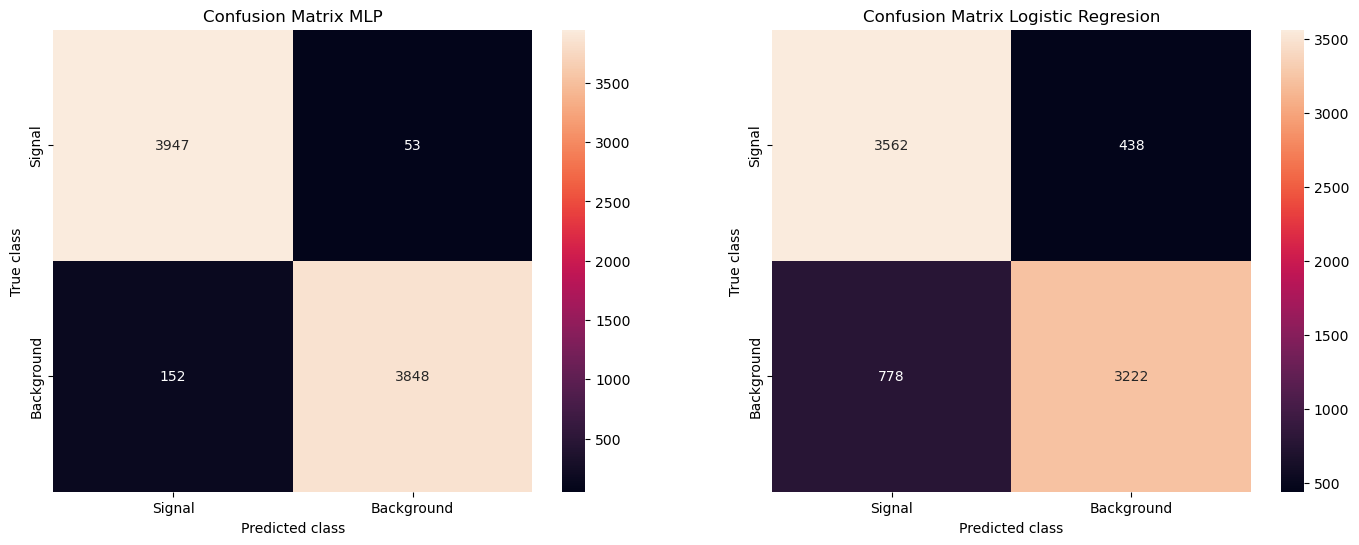

In [18]:
# Create confussion Matrix and rates

from sklearn.metrics import confusion_matrix
def rates(conf_matrix):
    TN = conf_matrix[0,0]
    FP = conf_matrix[0,1]
    FN = conf_matrix[1,0]
    TP = conf_matrix[1,1]
    fpr = (FP/(FP+TN)*100)
    tpr = (TP/(TP+FN)*100)
    return tpr, fpr
    

# Define the threshold for the prediction labels (1,0)

sb_label = ["Signal", "Background"] # labels = [1, 0]
threshold = 0.5 


# Transforming the predicted to (1,0) using the threshold 

y_mlp = [1 if y_val > threshold else 0 for y_val in prediction_mlp]
y_reg = [1 if y_val > threshold else 0 for y_val in prediction_reg]
y_mlp = np.array(y_mlp)
y_reg = np.array(y_reg)


# Calculate confusion matrix

confusion_matrix_mlp = confusion_matrix(target, y_mlp)
confusion_matrix_reg = confusion_matrix(target, y_reg)


# Plotting

plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
plt.title("Confusion Matrix MLP")
sns.heatmap(confusion_matrix_mlp, xticklabels=sb_label, yticklabels=sb_label, annot=True, fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.subplot(1,2,2)
plt.title("Confusion Matrix Logistic Regresion")
sns.heatmap(confusion_matrix_reg, xticklabels=sb_label, yticklabels=sb_label, annot=True, fmt="d")
plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.savefig("confusion_matrix_comparison_MLP_LogReg.png", dpi = 300)
# Rates for both models

tpr_mlp, fpr_mlp = rates(confusion_matrix_mlp)
tpr_reg, fpr_reg = rates(confusion_matrix_reg)
    
print(f"The True Positive Rate:  tpr_MLP = {tpr_mlp:.2f},  tpr_reg = {tpr_reg:.2f}")
print(f"The False Positive Rate:  fpr_MLP = {fpr_mlp:.2f},  fpr_reg = {fpr_reg:.2f}")

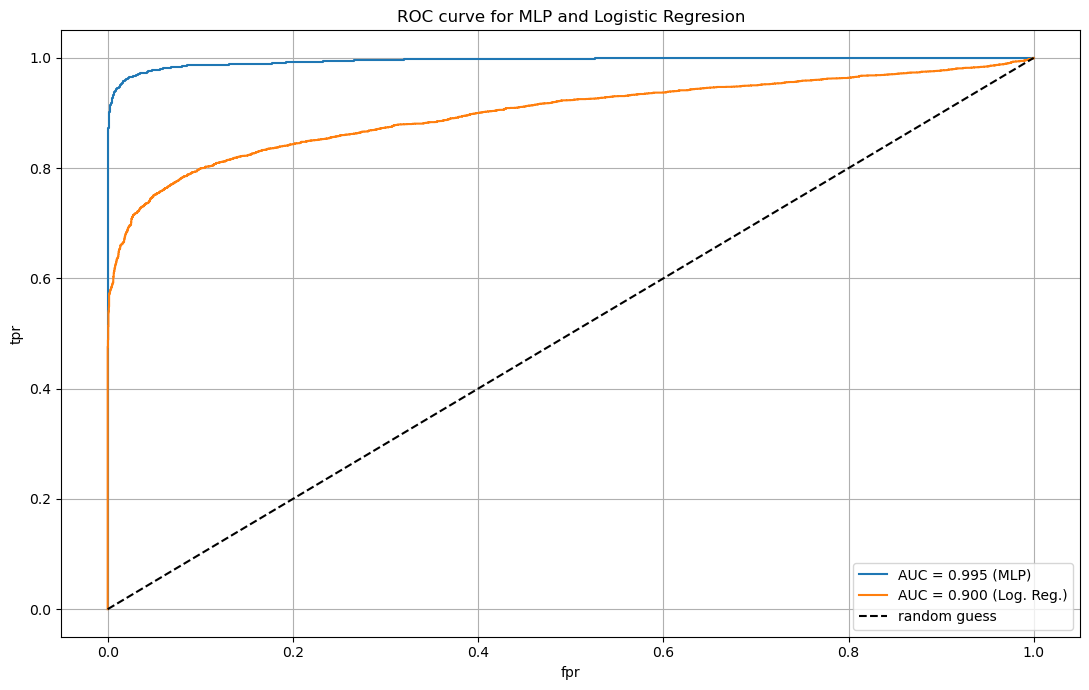

In [35]:
# Create ROC curve comparison (Assuming no Overfitting)
from sklearn.metrics import roc_curve, auc


# Calculationg fpr and tpr at different thresholds using roc_curve

fpr_roc_mlp, tpr_roc_mlp, thresholds_mlp = roc_curve(target, prediction_mlp, pos_label = 1)
fpr_roc_reg, tpr_roc_reg, thresholds_reg = roc_curve(target, prediction_reg, pos_label = 1)

# Area under curve ()

auc_mlp = auc(fpr_roc_mlp, tpr_roc_mlp)
auc_reg = auc(fpr_roc_reg, tpr_roc_reg)


# Plot ROC

plt.figure(figsize = (11,7))
plt.title("ROC curve for MLP and Logistic Regresion")
plt.plot(fpr_roc_mlp, tpr_roc_mlp, label = f"AUC = {auc_mlp:.3f} (MLP)")
plt.plot(fpr_roc_reg, tpr_roc_reg, label = f"AUC = {auc_reg:.3f} (Log. Reg.)")
plt.plot([0,1],[0,1], linestyle = "--", color = "k", label = "random guess")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.grid()
plt.legend()
plt.tight_layout()

plt.savefig("ROC_comparison_MLP_LogReg.png", dpi = 300)